
This post will discuss tools for designing and evaluating experiments. These tools offer user-friendly methods to estimate statistical power when working with multiple treatments or variants. They also help with sample allocation, including determining sample sizes for treatment and control groups. Lastly, they estimate power based on different expected effects (e.g., minimum detectable effects or MDE).

Calculating power for complex and uplift models using machine learning can be challenging. I will provide some general guidelines and references at the end of this post.

## Let's start with some terms

When conducting a statistical test to estimate an effect, we can have any of the following outcomes:

<p align="center">
  <img src="/assets/img/pregnant-power.jpg" alt="Image" width="70%" height="70%" />
</p>

These errors and success probabilities are associated with standard statistical terms used in making inferences.

- **Type I Error ($$\alpha$$)**: the probability of rejecting the null hypothesis
when it's true.
- **Type II Error ($$\beta$$)**: the probability of failing to reject the null
hypothesis when it's false.
- **Power ($$1-\beta$$)**: the probability of rejecting the null hypothesis when
it's false.
- **Confidence ($$1-\alpha$$)**: the probability of failing to reject the null
hypothesis when it's true.

As a standard, $$\alpha$$ is set to 0.05 and power to .80. Also, we will generally
have a control group (no intervention) and different treatments (variants). 

## There are some challenges

There are some challenges associated with basic power calculations (e.g., web
calculators): 

- **(Simultaneous) multiple comparisons**
- **Sample allocation**
- **Different MDEs by variant**

When conducting multiple statistical tests or comparisons within a study or analysis, there is a risk of obtaining false positive results. To address this, we need to adjust our $$\alpha$$ level based on the number of tests performed. This adjustment increases the required sample size to achieve statistical significance. It is important to consider this issue during experiment design and data analysis, including post hoc analyses.

To gain an understanding of why multiple comparison testing poses a challenge, let's consider a simple example. Suppose we have a control group and three treatment variants. In this example, we will simulate data where there are no effects or differences between the control and treatment groups. In other words, the null hypothesis (i.e., no effect) is always true. In each iteration, we test the control group against each treatment and count the number of significant results we obtain using a significance level ($$\alpha=0.05$$). It is important to note that we already know there are no differences between the groups.

In [1]:
from scipy.stats import ttest_ind
import pandas as pd
pd.set_option("display.notebook_repr_html", False)
import numpy as np
np.random.seed(0)

# Number of iterations for simulation
iterations = 1000

# Number of treatment groups
groups = 3

# Number of samples in each group
samples = 1000

# Count of batches where at least one false positive (Type I error) occurs
batches_with_errors = 0

# perform iterations
for _ in range(iterations):
    # Control group data
    control_group = np.random.normal(0, 1, samples)

    # Treatment group data - no actual difference from control
    treatment_groups = [np.random.normal(0, 1, samples) for _ in range(groups)]

    # A flag for any error within this batch of tests
    error_in_batch = False

    # perform t-test for each treatment group compared to control group
    for treatment in treatment_groups:
        t_stat, p_value = ttest_ind(control_group, treatment)

        # Check if p-value is less than 0.05 (significance level)
        if p_value < 0.05:
            error_in_batch = True
            break  # no need to check remaining tests

    if error_in_batch:
        batches_with_errors += 1

print(f"Probability of at least one Type I error in a batch of {groups} tests: {batches_with_errors / iterations * 100}%")

Probability of at least one Type I error in a batch of 3 tests: 12.6%


After 1000 iterations, the probability of encountering at least one Type I error in a batch of 3 tests is 12.6%. You can also use the formula: 

$$ 1 - (1 - \alpha)^n$$

Where $$n$$ is the number of comparisons. For this example, FWER will be 14.2%. This probability is referred to as the **Family-wise Error Rate (FWER)**, which signifies the likelihood of committing at least one Type I error within the entire family (or batch) of comparisons. It is evident that 12.6% and 14.2% are higher than the assumed α value of 5% for a single test. 

This is the essence of the multiple comparison problem. When conducting multiple tests, even if you maintain an $$\alpha$$ level of approximately 0.05 for each individual test, the likelihood of experiencing at least one false discovery among the entire set of tests is significantly higher and increases as the number of tests in the batch grows. Consequently, some of our significant findings may actually be false positives and difficult to replicate.

The key to adjusting multiple comparison testing is to strike a balance between reducing false positives (incorrectly rejecting the null hypothesis) and maintaining test power (the ability to correctly reject the null hypothesis when it's false). Some methods, such as *Bonferroni* or *Holm*, minimize the **Family-Wise Error Rate (FWER)**. Others, like *Benjamini-Hochberg*, minimize the **False Discovery Rate (FDR)**, which is the expected proportion of Type I errors among all declared significant hypotheses. FDR methods aim to reduce the ratio of Type I errors among significant results without eliminating all false discoveries like FWER methods. FDR methods generally offer higher statistical power and are less conservative.

A crucial element of experimental design lies in sample allocation. Variations in the distribution of samples among groups can influence the statistical power of our tests. Sometimes, the goal is to limit the potential disruption from an intervention by scaling down the sample size across various variants. Alternatively, we might opt to shrink the control group's size or allot more units to each variant, contingent on their Minimum Detectable Effect (MDE).

Let's not forget to consider expected effects. In figuring out the smallest minimum detectable effect (MDE), think about the least significant change that would still make the intervention worthwhile. It's all about balancing the books: estimate the return on investment (ROI) from the intervention, then determine the tiniest shift in a key metric (like conversion rates) that would still make the effort profitable. The MDE doesn't have to be identical across all variants - after all, not all interventions or campaigns cost the same.

## Tools can help

I've developed a set of straightforward simulation methods in Python, primarily to construct and evaluate our experimental data. The choice to use simulation was driven by its flexibility in handling diverse scenarios and metrics. However, it does come with a trade-off, as it demands a higher computational power. We can live with that :smile:. [Feel free to explore the code for the power class](https://github.com/sdaza/sdaza.github.io/tree/main/_jupyter/power_tools.py).

These methods are useful, particularly for handling multiple variants, different allocations, or MDE by group. However, it's important to note that these methods only offer a power estimate based on a given set of parameters. Therefore, we will need to conduct a grid search to evaluate various scenarios and determine the optimal one.

Let's start with a simple example using a proportion as the metric of interest:

In [2]:
from power_tools import * 

# load class
p = PowerSim(metric='proportion', relative_effect=False, variants=1, nsim=1000, alpha=0.05, alternative='two-tailed')

# get power
p.get_power(baseline=[0.33], effect=[0.03], sample_size=[3000])

NameError: name 'v' is not defined

`nsim` represents the number of simulations. Variants are set to 1, so we are
only comparing control and treatment: `comparisons = (0,1)`. This example is too
simple. Let's now assume two variants (treatments): 

In [ ]:
p = PowerSim(metric='proportion', relative_effect=False, variants=2, 
             nsim=1000, alpha=0.05, alternative='two-tailed')
p.get_power(baseline=[0.33], effect=[0.03], sample_size=[3000])

  comparisons  power
0      (0, 1)  0.531
1      (0, 2)  0.530
2      (1, 2)  0.015

The function calculates the power of group comparisons with a sample size of 3000 for each group. Multiple comparisons result in reduced power. Since the effect of each variant is the same (0.03), comparing *variants 1 and 2* is not meaningful here (it will always be 0 in practice). Custom comparisons can be defined using a list of tuples, such as `comparisons=[(0,1), (0,2)]`.

In [ ]:
p = PowerSim(metric='proportion', relative_effect=False, variants=2, 
             nsim=1000, alpha=0.05, alternative='two-tailed',
             comparisons=[(0,1), (0,2)])
p.get_power(baseline=[0.33], effect=[0.03], sample_size=[3000])

  comparisons  power
0      (0, 1)  0.558
1      (0, 2)  0.563

Using only two comparisons (each variant with a control), the power significantly decreases compared to the one-variant example. Currently, the method function offers three types of p-value corrections: 

- `bonferroni`
- `holm_bonferroni`
- `hochberg``
- `sidak`
- `fdr`

You can find an introduction to different methods [here](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). In general, Bonferroni is more conservative, while Holm provides higher power. The `fdr` method aims to minimize the false discovery rate.

The function corrects only for the comparisons specified in the `comparisons` parameter. If you conduct additional tests, such as comparing the performance of group A versus group B or examining differences among demographic groups, you need to apply additional multiple comparison corrections in your analysis.

We can introduce greater variability into the experimental design. We can then plot the expected power for different scenarios. To specify parameters, we'll utilize nested lists and the `grid_sim_power` method. However, things can quickly become convoluted.

Let's consider a more complex example. The impact of the first and second variants on the control group varies as follows: [0.01, 0.03], [0.03, 0.05], [0.03, 0.07]. The sample sizes are equal for each group, but they increase linearly. We apply the `holm` correction.

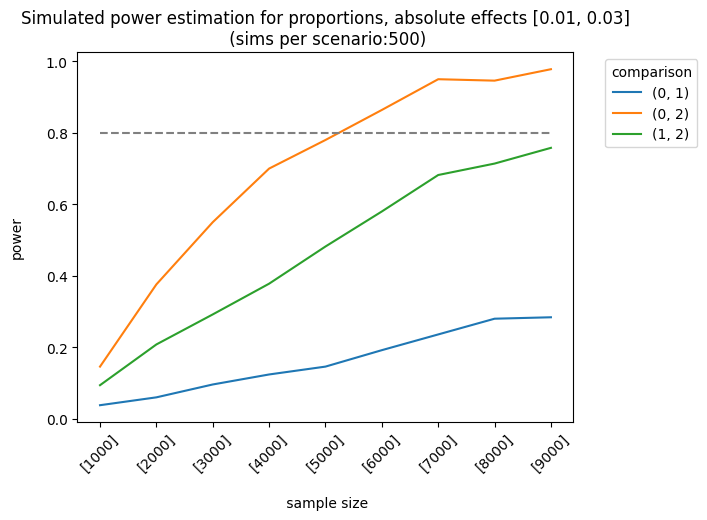

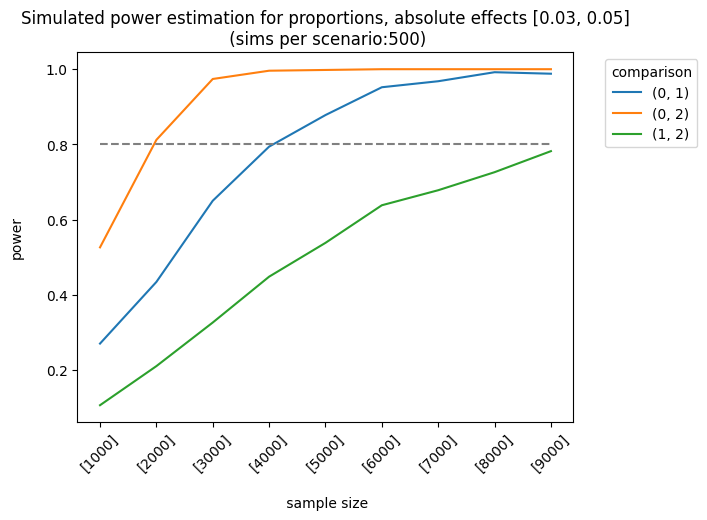

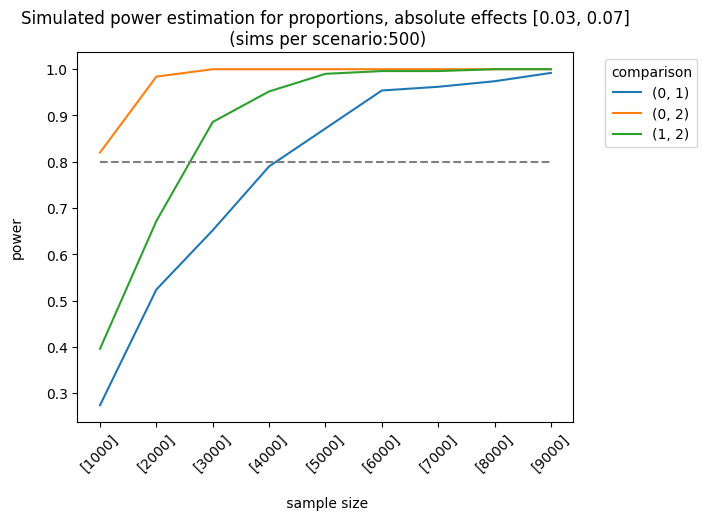

In [ ]:
p = PowerSim(metric='proportion', relative_effect=False, variants=2, alternative='two-tailed', 
	nsim=500, correction='fdr')
rr = p.grid_sim_power(baseline_rates=[[0.33]], 
                effects=[[0.01, 0.03], [0.03, 0.05], [0.03, 0.07]],
                sample_sizes= [[1000], [2000], [3000], [4000], [5000], [6000], [7000], [8000], [9000]], 
                threads=16, 
                plot=True)

As expected, the best scenario is when effect sizes are big enough to be
detected.  We can also use different sample allocations and explore their
consequences. You see that in the case of the effects `[0.03, 0.05]` , the
allocation `[3000, 7000, 7000]` provides relatively good results.  

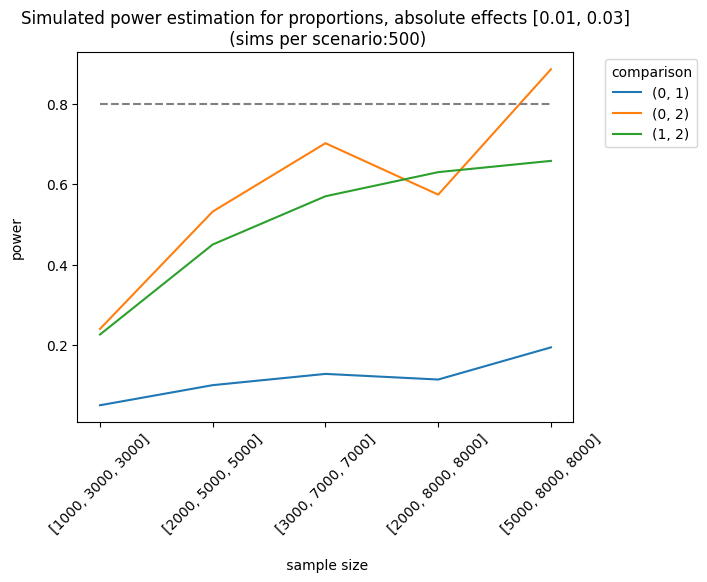

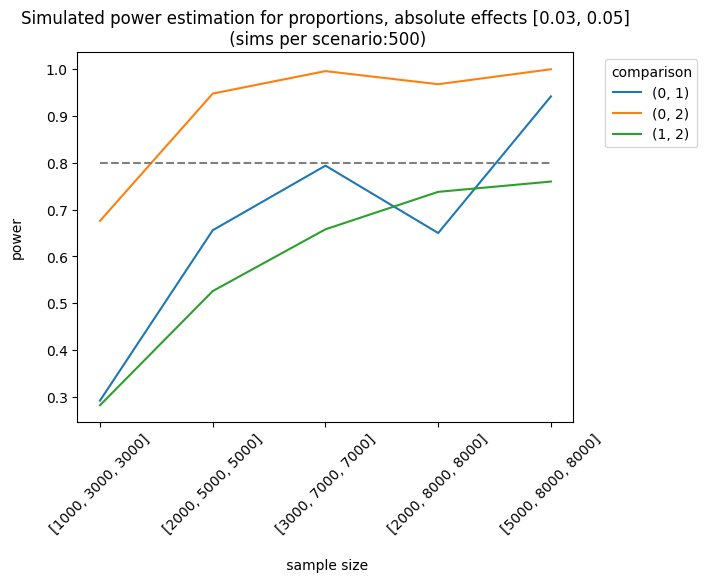

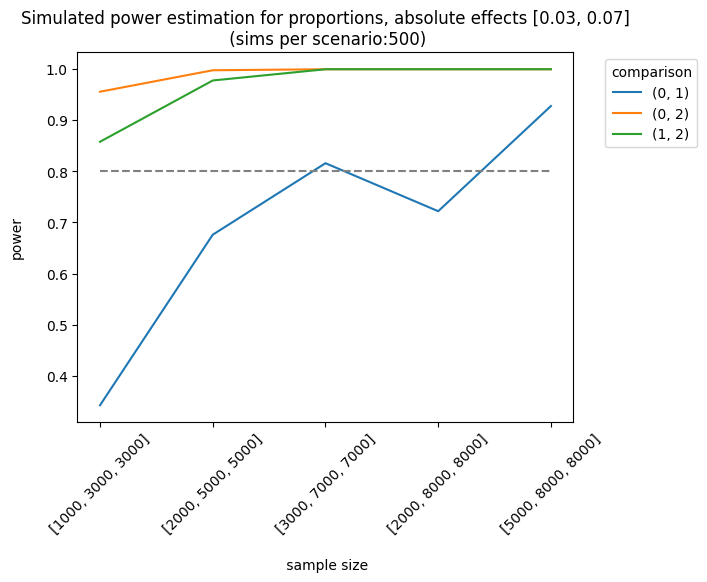

In [ ]:
p = PowerSim(metric='proportion', relative_effect=False, variants=2, 
             alternative='two-tailed', nsim=500, correction='holm')
rr = p.grid_sim_power(baseline_rates=[[0.33]], 
                effects=[[0.01, 0.03], [0.03, 0.05], [0.03, 0.07]],
                sample_sizes= [[1000, 3000, 3000], 
                               [2000, 5000, 5000], 
                               [3000, 7000, 7000], 
                               [2000, 8000, 8000],
                               [5000, 8000, 8000]],
                threads=16, 
                plot=True)

We can also use other metrics (e.g., average or counts).  For instance, we can
design an experiment where the outcome is the number of visits (counts). The simulator will use a
Poisson distribution with the parameter, $$\lambda$$ (lambda) or the mean
number of events. In this example, I set a baseline rate (lambda) of 1.2 visits
and a relative increase of $$0.05 (1.2*1.05) = 1.26$$, with a control group of
3000 users and a treatment of 5000 users:

In [ ]:
p = PowerSim(metric='count', relative_effect=True, variants=1, 
             alpha=0.05, alternative='two-tailed')
p.get_power(baseline=[1.2], effect=[0.05], sample_size=[3000, 5000])

  comparisons  power
0      (0, 1)   0.63

The effect is small, so our test is underpowered (<0.80). We can also use
averages (e.g., revenue), but in that case, we need to specify the standard
deviation of the groups:


In [ ]:
p = PowerSim(metric='average', relative_effect=False, variants=1, 
             alpha=0.05, alternative='two-tailed', nsim=5000)
p.get_power(baseline=[1000], effect=[100], standard_deviation=[600], sample_size=[400])

  comparisons   power
0      (0, 1)  0.6602

## Complex models 

When using uplift or mixed models, things become more complicated. As Aleksander
Molak put it: 

> The question of defining a "safe" dataset size for S-Learner and
other causal models is difficult to answer. Power calculations for machine
learning models are often difficult, if possible at all. 

There are some tricks we can apply, though, as Harrell suggests: 

> If you can afford a pilot study or you have some historical data that represents a problem similar to the one that
you’re interested in, you can find a subgroup in your data that is as homogenous
as possible. You can estimate the sample size for this group using some of the
traditional statistical power tools. Finally, scale your overall sample size so
that this subgroup is properly powered relative to the entire sample 

There are also some traditional ways to optimize the power of our tests:

- Blocking design
- Stratification and covariate adjustments (regression)

For instance, after learning from our uplift models, we can identify the key
features associated to users' responses. We can use those features to
design our experiments (blocking). We can also evaluate the results of our
uplift models in a new sample, and see if we can replicate the expected
`uplift`.

Here's a brief and general overview of the key features to keep in mind when designing experiments or improving models. I hope it's helpful.

<br>

*** 

## References

- Molak, Aleksander. *Causal Inference and Discovery in Python: Unlock the
secrets of modern causal machine learning with DoWhy, EconML, PyTorch and more*
. 
- https://www.fharrell.com/
- Ron Kohavi. *Trustworthy Online Controlled Experiments*.